In [1]:
import pyopia.background
import pyopia.classify
import pyopia.instrument.silcam
import pyopia.instrument.holo
import pyopia.io
import pyopia.pipeline
import pyopia.plotting
import pyopia.process
import pyopia.statistics
import exampledata

import xarray
import matplotlib.pyplot as plt

In [2]:
settings = pyopia.io.load_toml('config.toml')
settings

{'steps': {'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'load': {'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'},
  'imageprep': {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
   'image_level': 'imraw'},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.85},
  'statextract': {'pipeline_class': 'pyopia.process.CalculateStats'}}}

In [3]:
step_str = pyopia.io.build_step_string(settings)
step_str

"{'classifier': pyopia.classify.Classify(model_path='keras_model.h5'), 'load': pyopia.instrument.silcam.SilCamLoad(), 'imageprep': pyopia.instrument.silcam.ImagePrep(image_level='imraw'), 'segmentation': pyopia.process.Segment(threshold=0.85), 'statextract': pyopia.process.CalculateStats()}"

In [4]:
steps = eval(step_str)
steps

{'classifier': <pyopia.classify.Classify at 0x19ca4a90940>,
 'load': <pyopia.instrument.silcam.SilCamLoad at 0x19cac5bbcd0>,
 'imageprep': <pyopia.instrument.silcam.ImagePrep at 0x19caa9ecac0>,
 'segmentation': <pyopia.process.Segment at 0x19cac5e70a0>,
 'statextract': <pyopia.process.CalculateStats at 0x19cac5e7100>}

In [5]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(steps)

# Load an image (from the test suite)
filename = exampledata.get_example_silc_image()

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
  Running <pyopia.classify.Classify object at 0x0000019CA4A90940>
Pipeline ready with these data:  ['cl']
calling:  <class 'pyopia.instrument.silcam.SilCamLoad'>  with:  ['cl', 'filename', 'steps_string']
calling:  <class 'pyopia.instrument.silcam.ImagePrep'>  with:  ['cl', 'filename', 'steps_string', 'timestamp', 'imraw']
calling:  <class 'pyopia.process.Segment'>  with:  ['cl', 'filename', 'steps_string', 'timestamp', 'imraw', 'imref', 'imc']
segment
clean
calling:  <class 'pyopia.process.CalculateStats'>  with:  ['cl', 'filename', 'steps_string', 'timestamp', 'imraw', 'imref', 'imc', 'imbw']
statextract
21.7% saturation
measure
  870 particles found
WARNING. exportparticles temporarily modified for 2-d images without color!
EXTRACTING 870 IMAGES from 870


In [6]:
pyopia.io.write_stats(
        'proc/test',
        stats,
        steps_string=step_str,
        append=False,
        format='nc')

In [7]:
xstats = xarray.open_dataset('proc/test-STATS.nc')
xstats

<xarray.Dataset>
Dimensions:                     (index: 870)
Coordinates:
  * index                       (index) int32 0 1 2 3 4 ... 865 866 867 868 869
    time                        (index) datetime64[ns] ...
Data variables: (12/17)
    export name                 (index) object ...
    major_axis_length           (index) float64 ...
    minor_axis_length           (index) float64 ...
    equivalent_diameter         (index) float64 ...
    minr                        (index) float64 ...
    minc                        (index) float64 ...
    ...                          ...
    probability_faecal_pellets  (index) float64 ...
    probability_copepod         (index) float64 ...
    probability_diatom_chain    (index) float64 ...
    probability_oily_gas        (index) float64 ...
    timestamp                   (index) datetime64[ns] ...
    saturation                  (index) float64 ...
Attributes:
    steps:           {'classifier': pyopia.classify.Classify(model_path='kera...
    Modified:        2023-07-06 07:40:35.178801
    PyOpia version:  0.0.53

Text(0, 0.5, 'Volume Distribution [uL/sample vol.]')

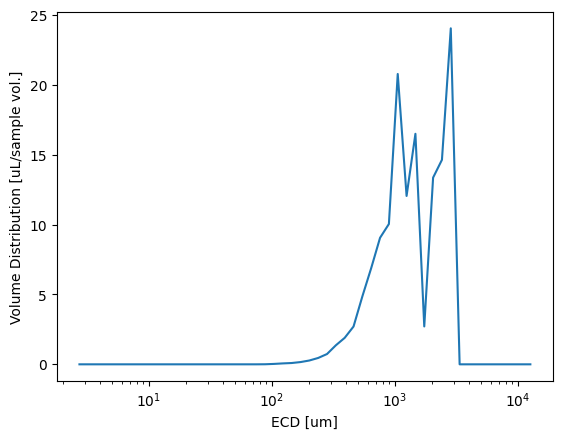

In [8]:
dias, vd = pyopia.statistics.vd_from_stats(xstats, 24)

# plot the volume distribution
plt.plot(dias, vd)
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')